# Задание

+ Генерирование выборки для заданных функций с моделированием случайной ошибки измерения.

  Использовать библиотеки Python numpy, math, модуль matplotlib.pyplot.

  1. Сформировать выборку $\{(x^{(i)}, y^{(i)})\}^N_{i=1}$:

    $y^{(i)} = f(x^{(i)})+\varepsilon$, где $\varepsilon$ - ошибка, генерируемая случайно из заданного интервала $[-\varepsilon_0, +\varepsilon_0]$, $\varepsilon_0>0$

    Аргументы $x^{(i)}$ генерируется случайно в соответствии с равномерным распределением на интервале $[-1, 1]$.

    Варианты распределения ошибки на интервале $[-\varepsilon_0, +\varepsilon_0]$:
    
    + Ошибка $\varepsilon$ распределена равномерно
    + Ошибка $\varepsilon$ распределена нормально

    Варианты функции f:

    + $f=ax^3+bx^2+cx+d$,где a, b, c, d - случайные коэффициенты с интервала $[-3; 3]$
    + $f=xsin(2 \pi x)$

  2. Отобразить на координатной плоскости график функции f и выборку, полученную по ней. Выбрать разные варианты значения $\varepsilon_0$ и разные параметры нормального распределения.

+ Восстановление функциональной зависимости с помощью полиномиальной регрессии.

  Реализовать при помощи полиномиальной регрессии для полученной выборки восстановление функциональной зависимости, по которой была получена выборка. Привести примеры выборок и степеней полиномов, при которых:

    + происходит недообучение
    + происходит переобучение
    + полученная функциональная зависимость пригодна для прогнозирования значения восстанавливаемой функциональной зависимости в x, не содержащемся в выборке

  Использовать библиотеки Python numpy, math, scipy, модуль matplotlib.pyplot.

# Решение

1. Функции генерации

In [27]:
import numpy as np
import math
import matplotlib.pyplot as plt

def random_polynomial():
    a, b, c, d = np.random.uniform(-3, 3, 4)
    def f(x):
        return a*x**3 + b*x**2 + c*x + d
    return f


def trig_function():
    def f(x):
        return x * np.sin(2*np.pi*x)
    return f

2. Генерация шума

In [62]:
def generate_noise(n, eps0, mode="uniform", sigma = eps0/3):
    if mode == "uniform":
        return np.random.uniform(-eps0, eps0, n)
    elif mode == "normal":
        return np.random.normal(0, sigma, n)
    else:
        raise ValueError("Unknown mode")

3. Генерация выборки

In [63]:
def generate_sample(f, N, eps0, noise_mode="uniform", sigma = eps0/3):
    x = np.random.uniform(-1, 1, N)
    noise = generate_noise(N, eps0, noise_mode, sigma)
    y = f(x) + noise
    return x, y

4. Визуализация функции и выборки

   Построим график истинной функции и точек выборки. Это позволяет визуально оценить влияние уровня шума.

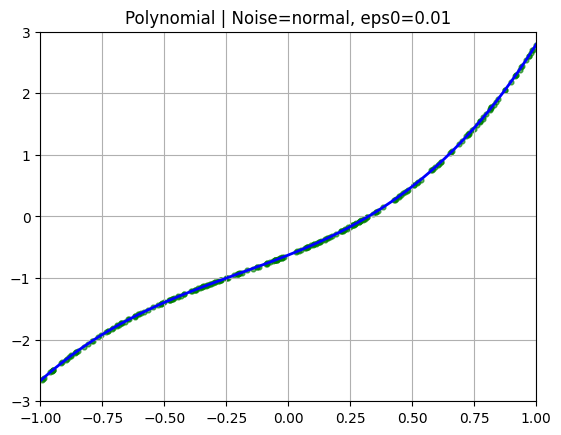

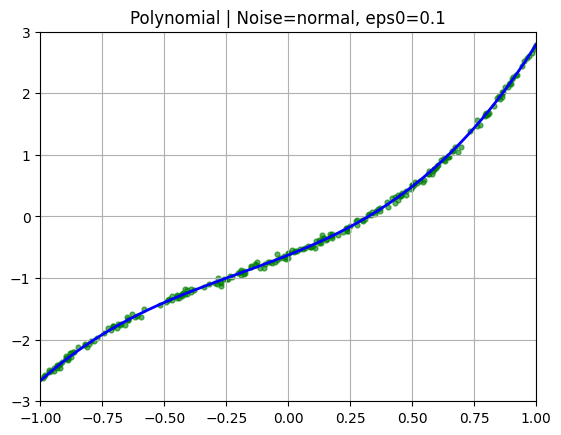

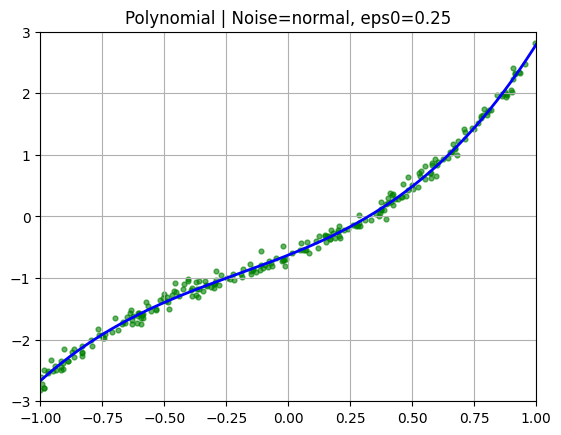

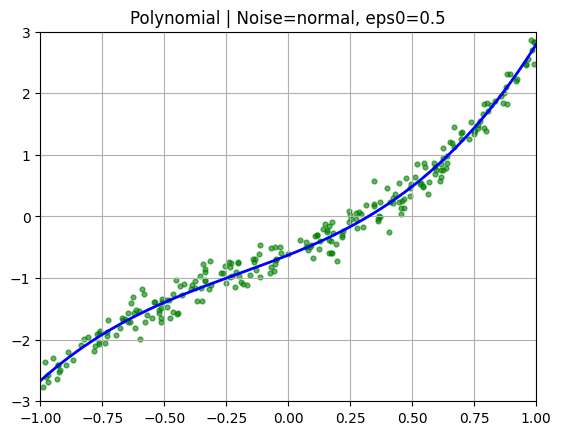

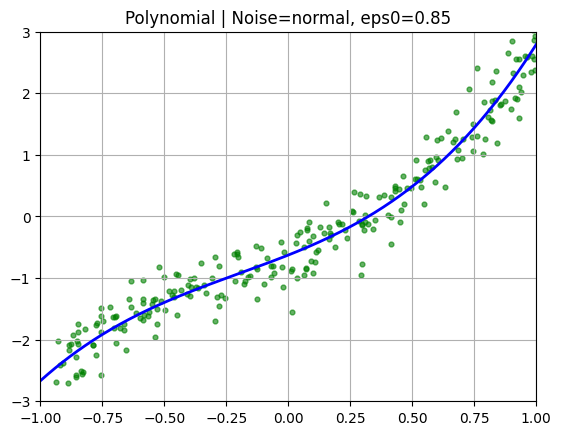

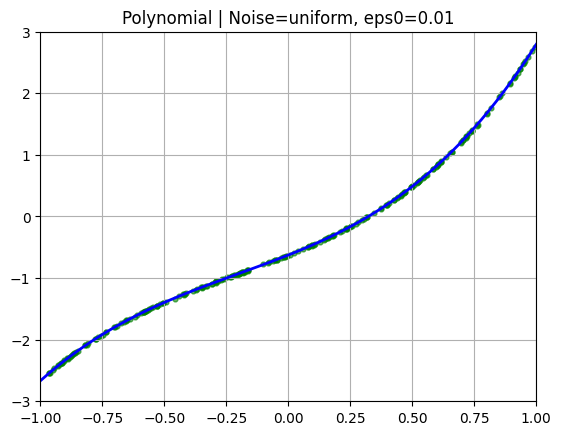

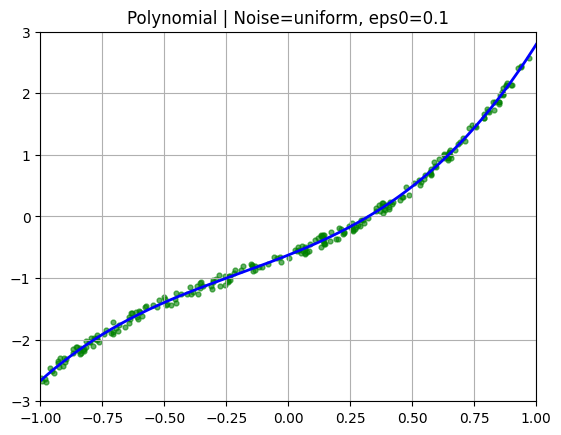

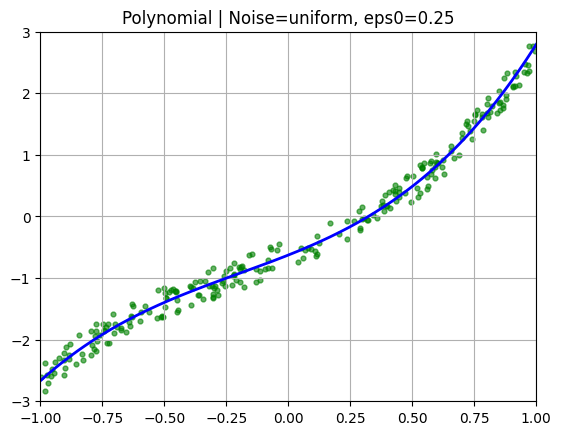

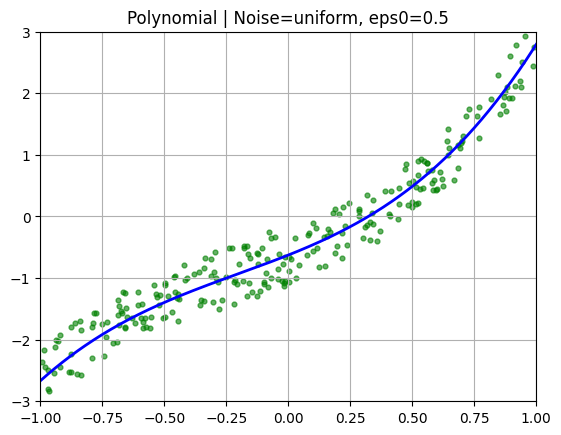

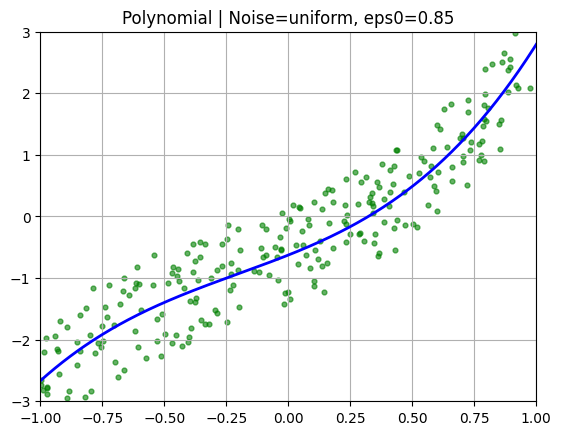

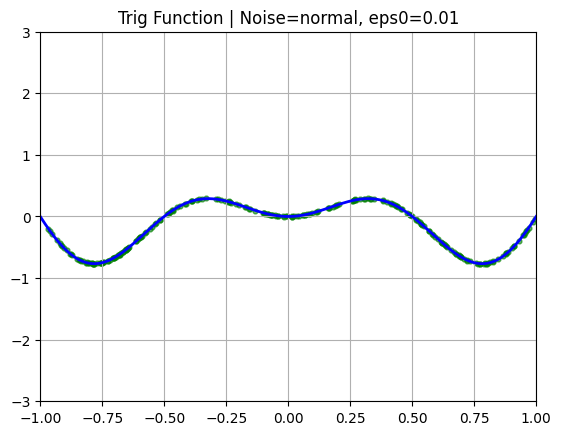

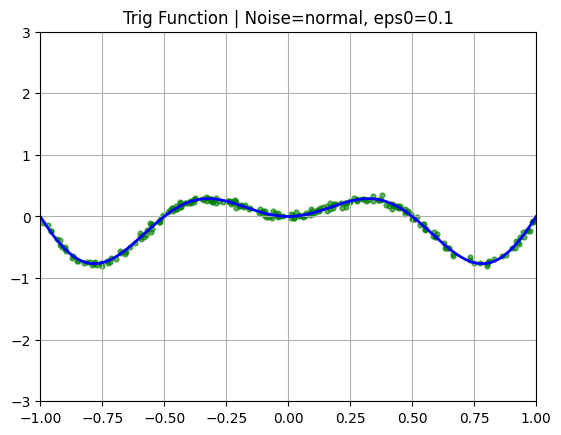

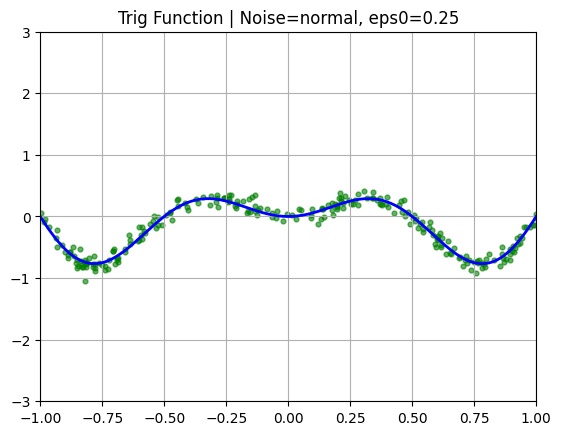

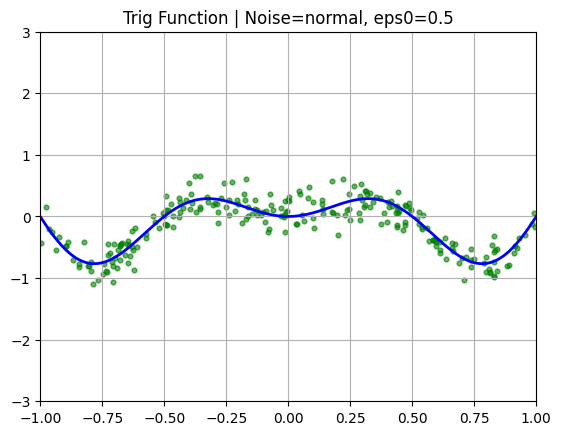

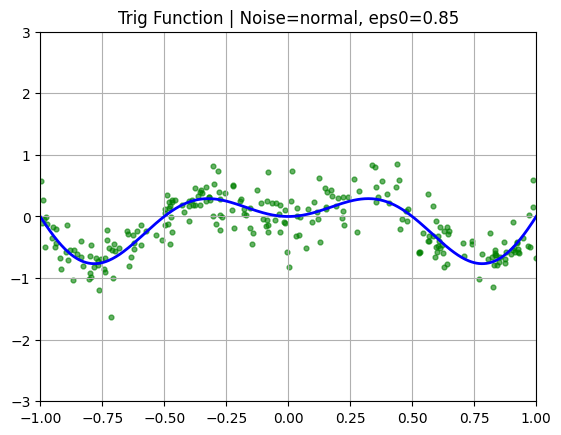

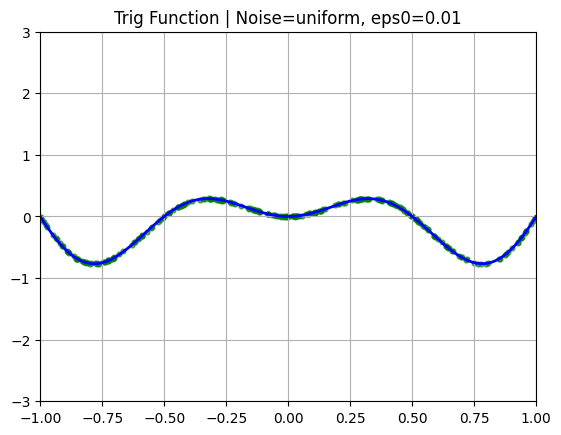

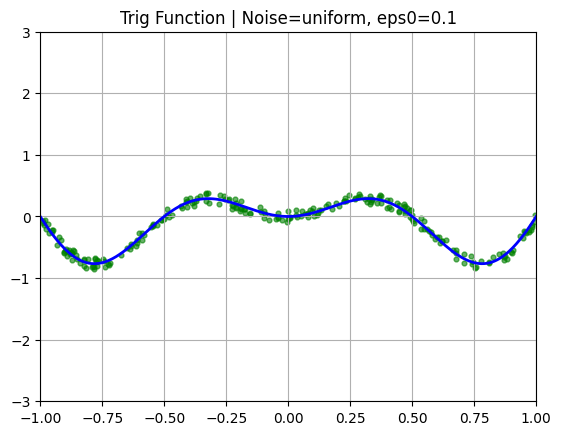

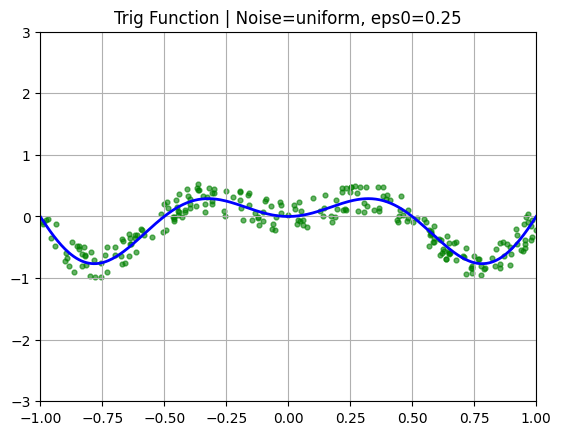

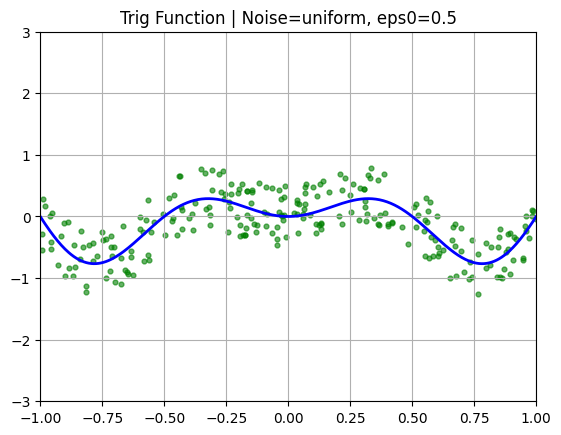

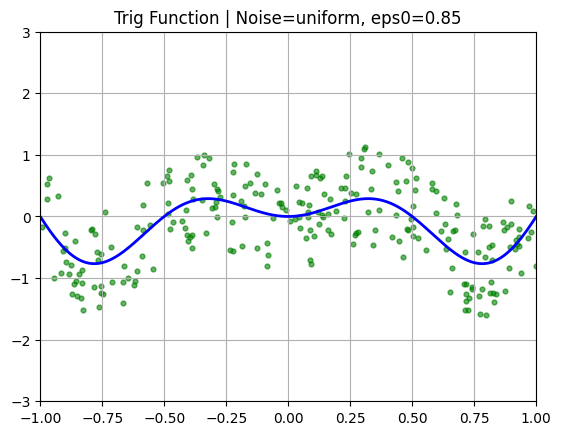

In [64]:
eps_values = [0.01, 0.1, 0.25, 0.5, 0.85]
noise_types = ["normal", "uniform"]

for func_idx in range(2):
    if func_idx == 0:
        f = random_polynomial()
        func_name = "Polynomial"
    else:
        f = trig_function()
        func_name = "Trig Function"

    x_dense = np.linspace(-1, 1, 400)
    y_dense = f(x_dense)

    for noise_mode in noise_types:
        for eps0 in eps_values:

            x_sample, y_sample = generate_sample(
                f,
                N=250,
                eps0=eps0,
                noise_mode=noise_mode,
                sigma=eps0/3
            )

            plt.figure()
            plt.scatter(x_sample, y_sample, color="green", alpha=0.6, s=12)
            plt.plot(x_dense, y_dense, color="blue", linewidth=2)

            plt.xlim(-1, 1)
            plt.ylim(-3, 3)
            plt.grid(True)
            plt.title(f"{func_name} | Noise={noise_mode}, eps0={eps0}")
            plt.show()

## Полиномиальная регрессия через систему линейных уравнений

Восстановление зависимости выполняется методом наименьших квадратов
через решение системы линейных алгебраических уравнений:


$ \sum_{j=0}^{M} a_{ij} w_j = b_i $

где

$ a_{ij}=\sum_{k=1}^{N} x_k^{i+j}, \qquad
b_i=\sum_{k=1}^{N} x_k^i y_k $

Полученные коэффициенты \(w_j\) задают аппроксимирующий полином

$ \hat f(x)=\sum_{j=0}^{M} w_j x^j $

In [65]:
def train_test_split(x, y, test_ratio=0.3):
    idx = np.random.permutation(len(x))
    split = int(len(x) * (1 - test_ratio))

    train_idx = idx[:split]
    test_idx = idx[split:]

    return x[train_idx], x[test_idx], y[train_idx], y[test_idx]

In [66]:
def build_normal_system(x, y, M):
    N = len(x)

    A = np.zeros((M+1, M+1))
    b = np.zeros(M+1)

    for i in range(M+1):
        for j in range(M+1):
            A[i, j] = np.sum(x**(i+j))

        b[i] = np.sum((x**i) * y)

    return A, b

In [67]:
def poly_fit_normal_eq(x, y, degree):
    A, b = build_normal_system(x, y, degree)
    w = np.linalg.solve(A, b)
    return w

In [68]:
def poly_predict(w, x):
    y = np.zeros_like(x, dtype=float)
    for j in range(len(w)):
        y += w[j] * x**j
    return y

In [69]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

Degree | Train MSE | Test MSE
--------------------------------
     0 |   0.421234 |   0.423682
     1 |   0.421207 |   0.423926
     2 |   0.310954 |   0.286918
     3 |   0.310946 |   0.287184
     4 |   0.285036 |   0.259450
     5 |   0.284482 |   0.265703
     6 |   0.224236 |   0.234450
     7 |   0.224205 |   0.235632
     8 |   0.213872 |   0.217696
     9 |   0.212826 |   0.212552
    10 |   0.211779 |   0.210163
    11 |   0.209987 |   0.211631
    12 |   0.209982 |   0.211849
    13 |   0.202156 |   0.238859
    14 |   0.202136 |   0.240022
    15 |   0.191505 |   0.324010
Underfit degree: 1
Good degree: 10
Overfit degree: 15


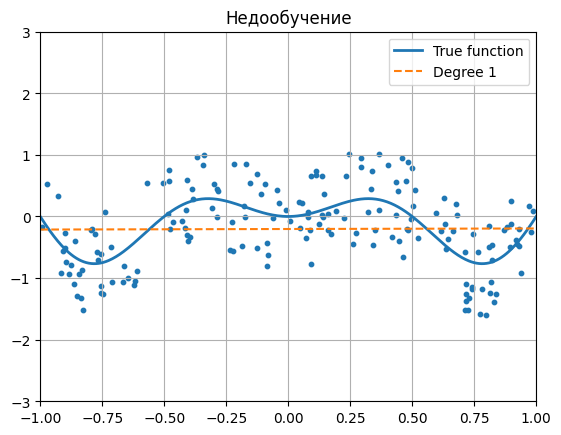

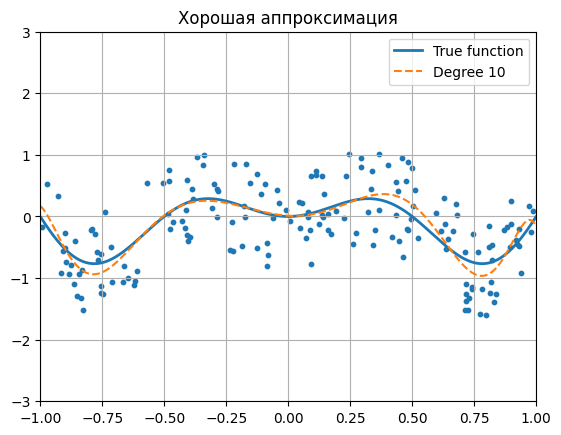

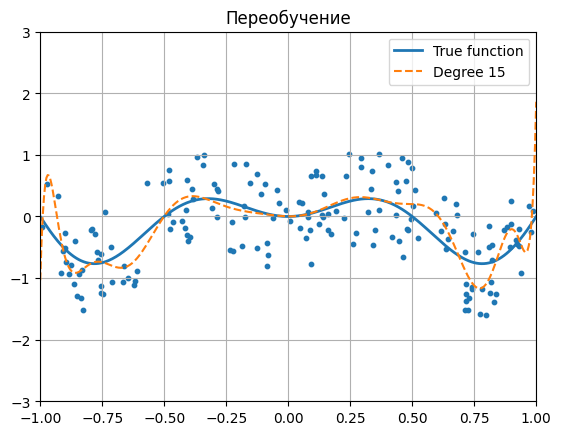

In [70]:
max_deg = 15

x_train, x_test, y_train, y_test = train_test_split(x_sample, y_sample)

train_errors = []
test_errors = []
degrees = list(range(max_deg + 1))

for deg in degrees:

    w = poly_fit_normal_eq(x_train, y_train, deg)

    train_pred = poly_predict(w, x_train)
    test_pred  = poly_predict(w, x_test)

    train_errors.append(mse(y_train, train_pred))
    test_errors.append(mse(y_test, test_pred))


print("Degree | Train MSE | Test MSE")
print("--------------------------------")

for d, tr, te in zip(degrees, train_errors, test_errors):
    print(f"{d:6d} | {tr:10.6f} | {te:10.6f}")

under_deg = degrees[np.argmax(test_errors)]

good_deg = degrees[np.argmin(test_errors)]

over_deg = max_deg

print("Underfit degree:", under_deg)
print("Good degree:", good_deg)
print("Overfit degree:", over_deg)

def plot_model(deg, title):

    w = poly_fit_normal_eq(x_train, y_train, deg)

    x_dense = np.linspace(-1, 1, 400)
    y_true = f(x_dense)
    y_pred = poly_predict(w, x_dense)

    plt.figure()

    plt.plot(x_dense, y_true, linewidth=2, label="True function")
    plt.plot(x_dense, y_pred, linestyle="--", label=f"Degree {deg}")

    plt.scatter(x_train, y_train, s=10)

    plt.xlim(-1,1)
    plt.ylim(-3,3)
    plt.grid(True)
    plt.legend()
    plt.title(title)

    plt.show()
    
plot_model(under_deg, "Недообучение")
plot_model(good_deg,  "Хорошая аппроксимация")
plot_model(over_deg,  "Переобучение")
